<h1>Build feature and output arrays

In [42]:
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import OneHotEncoder

# lists for all data
all_turbine_types = []
all_hub_heights = []
all_capacities = []
all_commissioning_dates = []
all_production_data = []

with open(f"../data/WPPs+production+reanalysis/WPPs+production+wind_new.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# collect data
for wpp in WPP_production_wind:
    all_turbine_types.append(str(wpp["Turbine"]))
    all_hub_heights.append(wpp["Hub_height"])
    all_capacities.append(wpp["Capacity"])
    all_commissioning_dates.append(f"{wpp['Commissioning_date']}/06" if isinstance(wpp["Commissioning_date"], str) and "/" not in wpp["Commissioning_date"] else wpp["Commissioning_date"])
    all_production_data.append(wpp["Production"])

# One-Hot-Encoding for turbine types
encoder = OneHotEncoder(sparse_output=False)
turbine_types_onehot = encoder.fit_transform(np.array(all_turbine_types).reshape(-1, 1))

# convert to datetime
standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

# calculate age
current_date = pd.Timestamp("2024-12-01")
ages = current_date.year * 12 + current_date.month - (standardised_dates.year * 12 + standardised_dates.month)

# create combined features and output lists
combined_features_raw = []
output_raw = []

# convert data in feature arrays
for idx, production_data in enumerate(all_production_data):
    num_rows = len(production_data)

    # repetitions for common features
    turbine_type_repeated = np.tile(turbine_types_onehot[idx], (num_rows, 1))
    hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
    age_repeated = np.full((num_rows, 1), ages[idx])
    capacities_repeated = np.full((num_rows, 1), all_capacities[idx])

    # extract production values and wind speeds
    production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1) / all_capacities[idx]
    wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

    # combine all features
    combined_chunk = np.hstack((
        turbine_type_repeated,
        hub_height_repeated,
        age_repeated,
        wind_speeds
    ))

    # add the data
    combined_features_raw.append(combined_chunk)
    output_raw.append(production_values)

np.save("parameters/turbine_types_order.npy", encoder.categories_[0])

# combine all data chunks to one array
combined_features_raw = np.vstack(combined_features_raw)
output_raw = np.vstack(output_raw)

# round all values to two decimal places
combined_features_raw = np.round(combined_features_raw, decimals=4)
output_raw = np.round(output_raw, decimals=4)

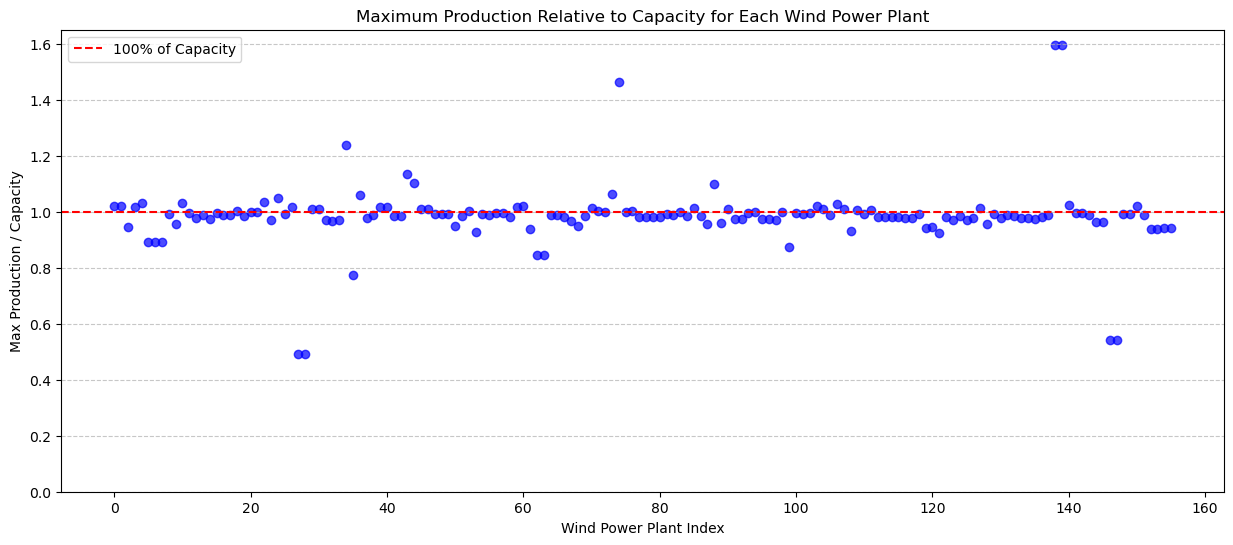

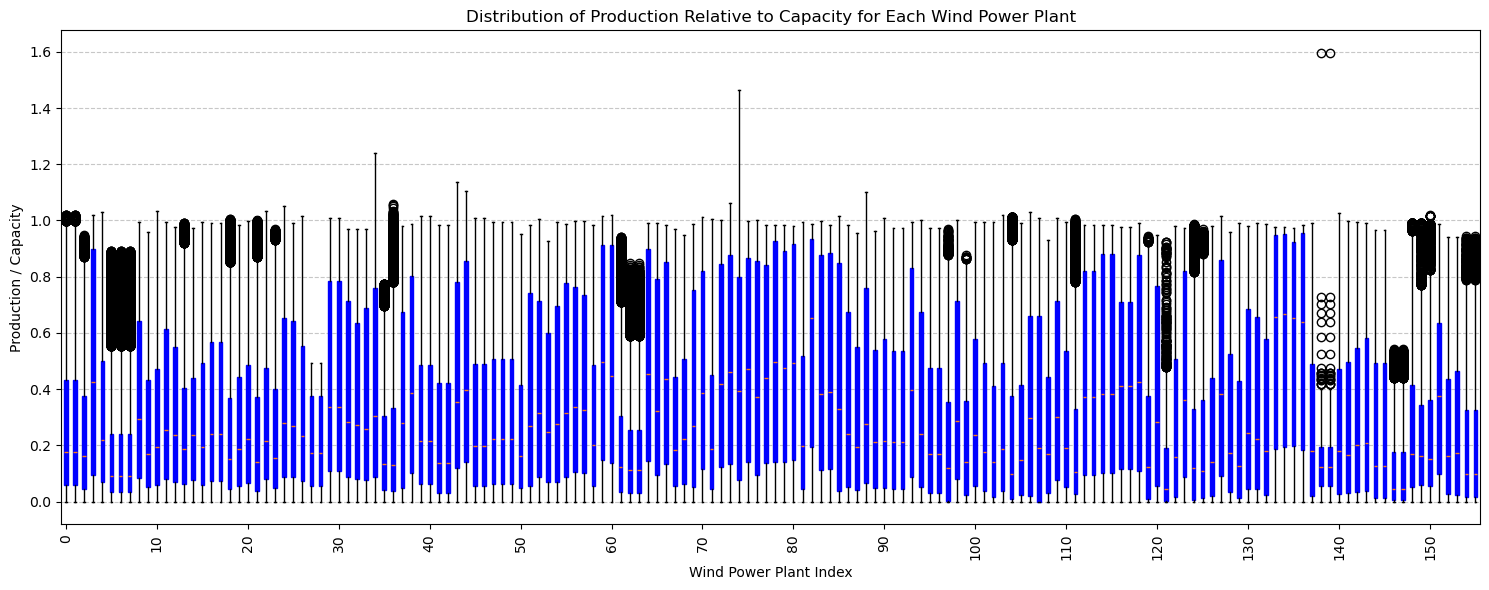

In [2]:
import matplotlib.pyplot as plt

# Prepare data for the boxplot (one boxplot per WPP)
production_ratios_per_wpp = [[entry[1] / capacity for entry in production_data] for production_data, capacity in zip(all_production_data, all_capacities)]
max_production_ratio_per_wpp = [max(ratios) for ratios in production_ratios_per_wpp]

# Plotting
plt.figure(figsize=(15, 6))
plt.scatter(range(len(max_production_ratio_per_wpp)), max_production_ratio_per_wpp, alpha=0.7, c='blue')
plt.axhline(y=1.0, color='red', linestyle='--', label='100% of Capacity')
plt.xlabel('Wind Power Plant Index')
plt.ylabel('Max Production / Capacity')
plt.title('Maximum Production Relative to Capacity for Each Wind Power Plant')
plt.ylim(0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Plot boxplot with thin boxes
plt.figure(figsize=(15, 6))
plt.boxplot(production_ratios_per_wpp, widths=0.4, vert=True, patch_artist=True, showfliers=True, boxprops=dict(facecolor='blue', color='blue'))
plt.xlabel('Wind Power Plant Index')
plt.ylabel('Production / Capacity')
plt.title('Distribution of Production Relative to Capacity for Each Wind Power Plant')
step = 10  # Interval for the ticks
num_wpps = len(all_production_data)
tick_positions = np.arange(0, num_wpps, step) + 1  # 1-indexed positions for boxplot
tick_labels = np.arange(0, num_wpps, step)  # Actual WPP indices (0, 10, 20, ...)
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

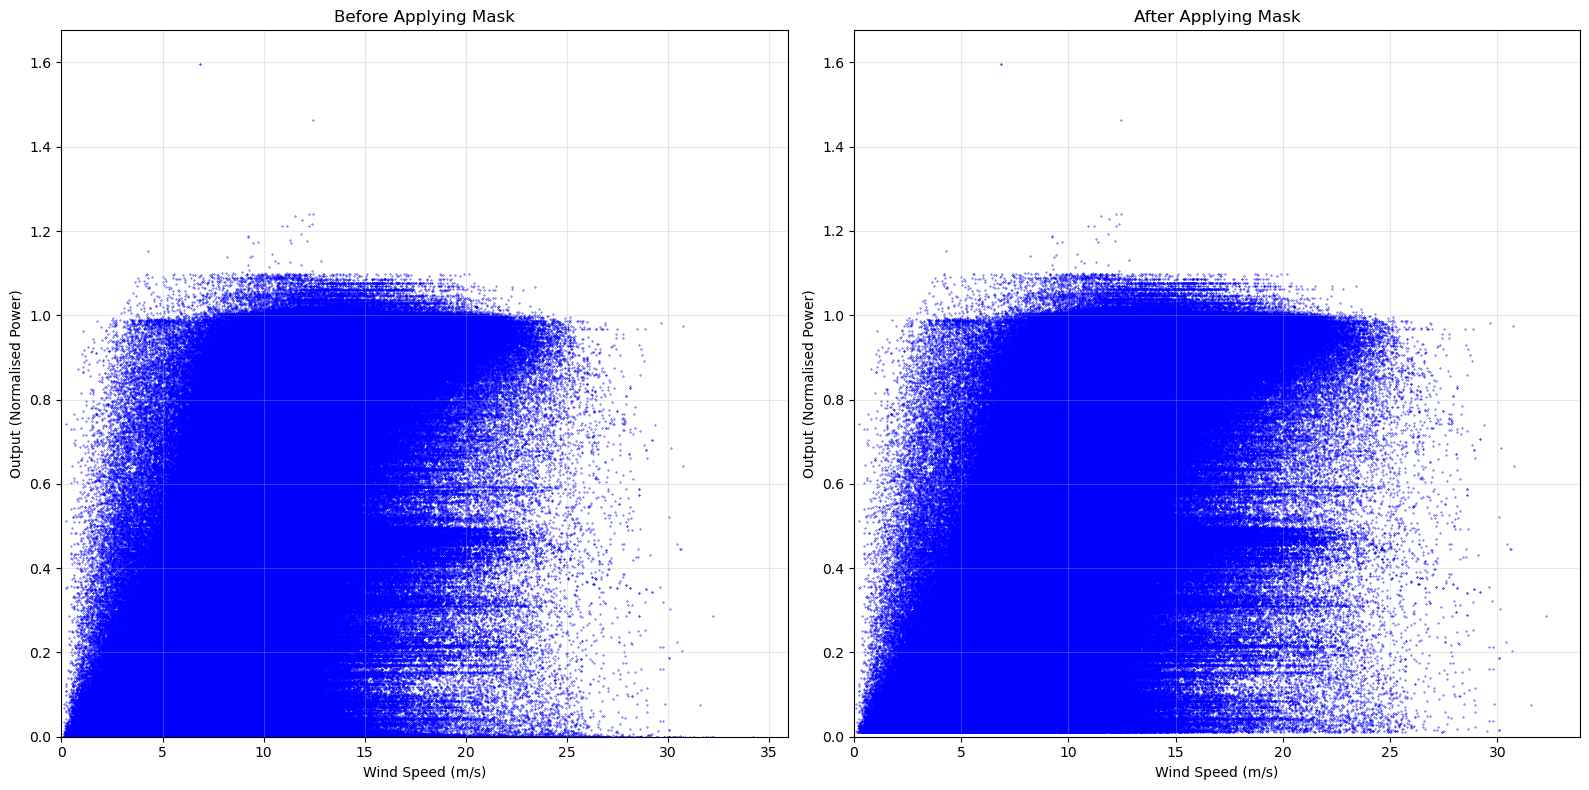

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Erstelle eine Maske mit 10.000 zufälligen Indizes
random_indices = np.random.choice(combined_features_raw.shape[0], 10000, replace=False)

combined_features_subset = combined_features_raw.copy()
output_subset = output_raw.copy()

# Extrahiere die entsprechenden Werte aus den Arrays
combined_features_subset = combined_features_subset[random_indices]
output_subset = output_subset[random_indices]

# mask = ~((output_subset.flatten() < 0.01) & (combined_features_subset[:, -1] > 7.0))
mask = output_subset.flatten() > 0.01

# Apply the mask to filter the subsets
combined_features_filtered = combined_features_subset[mask]
output_filtered = output_subset[mask]

# Generate a 2x1 plot to compare before and after applying the mask

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot before applying the mask
axes[0].scatter(combined_features_subset[:, -1], output_subset, s=0.01, color='blue')
axes[0].set_title("Before Applying Mask")
axes[0].set_xlabel("Wind Speed (m/s)")
axes[0].set_ylabel("Output (Normalised Power)")
axes[0].set_xlim(left=0)
axes[0].set_ylim(bottom=0)
axes[0].grid(alpha=0.3)

# Plot after applying the mask
axes[1].scatter(combined_features_filtered[:, -1], output_filtered, s=0.01, color='blue')
axes[1].set_title("After Applying Mask")
axes[1].set_xlabel("Wind Speed (m/s)")
axes[1].set_ylabel("Output (Normalised Power)")
axes[1].set_xlim(left=0)
axes[1].set_ylim(bottom=0)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

<h1>Scale feature vector and define Dataset

In [9]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
import torch
import joblib

choice = 0
if choice == 0:
    combined_features = combined_features_raw.copy()
    output = output_raw.copy()
elif choice == 1:
    combined_features = combined_features_subset.copy()
    output = output_subset.copy()
else:
    combined_features = combined_features_filtered.copy()
    output = output_filtered.copy()


# Separate Scaler für jedes Feature
scaler_wind = StandardScaler()
scaler_ages = StandardScaler()
scaler_hub_heights = StandardScaler()

# Skalieren der einzelnen Features
combined_features[:, -1] = scaler_wind.fit_transform(combined_features[:, -1].reshape(-1, 1)).flatten() # scale wind speeds
combined_features[:, -2] = scaler_ages.fit_transform(combined_features[:, -2].reshape(-1, 1)).flatten()  # scale ages
combined_features[:, -3] = scaler_hub_heights.fit_transform(combined_features[:, -3].reshape(-1, 1)).flatten()  # scale hub heights

# Speichere alle Scaler in einem Dictionary
scalers = {
    "winds": scaler_wind,
    "ages": scaler_ages,
    "hub_heights": scaler_hub_heights,
}

# Speichere das Dictionary mit Joblib
joblib.dump(scalers, "parameters/scalers.pkl")

# Dataset-Klasse für PyTorch
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Erstellung der PyTorch-Datasets
dataset = WindPowerDataset(combined_features, output)

<h1>Define and visualise Model

In [10]:
import torch.nn as nn
import torch
from torch.utils.tensorboard import SummaryWriter

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3366)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)  # No activation in the output layer for regression
        return x
    
# Create a dummy input with the same shape as your model's input
input_size = torch.load("parameters/input_size", weights_only=True)
dummy_input = torch.rand(1, input_size)  # Batch size of 1, with "input_size" features

# Instantiate your model
model = MLP(input_size=input_size)

# Initialize the TensorBoard writer
writer = SummaryWriter("runs/mlp_model")

# Add the model graph to TensorBoard
writer.add_graph(model, dummy_input)

# Close the writer
writer.close()

<h1>Training, Testing and deployment in one</h1>
The computing resources on the personal PC are

• 4 physical CPU cores, with Hyper-Threading 4 additional virtual CPU cores --> 8 logical CPU cores

• 1 integrated GPU, that can be used with import torch_directml, device = torch_directml.device(), but it is much slower than the CPUs (and doesn't support HuberLoss: this calculation must be outsourced to the CPU. And no float64, only float32 datatypes)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

params = {"batch_size": 128,
 "lr": 0.00010155,
 "number_epochs": 10}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False)

# Model
input_size = combined_features.shape[1]
model = MLP(input_size=input_size).to(device)

# Loss function and optimizer
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=params["lr"])

# Training
for epoch in range(params["number_epochs"]):
    print(f"Epoch {epoch + 1}/{params['number_epochs']}")
    model.train()
    training_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)

        loss = criterion(outputs, batch_y)

        training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Training Loss: {training_loss / len(train_loader):.4f}")

# Validation
model.eval()
val_loss = 0.0
mae_loss = 0.0
mse_loss = 0.0

# For later visualisation
batch_x_all = []
batch_y_all = []
val_outputs_all = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x_all.append(batch_x.detach().cpu().numpy())
        batch_y_all.append(batch_y.detach().cpu().numpy())

        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        val_outputs = model(batch_x)

        val_outputs_all.append(val_outputs.detach().cpu().numpy())

        val_loss += criterion(val_outputs, batch_y).item()  # Huber loss
        mae_loss += nn.L1Loss()(val_outputs, batch_y).item()  # MAE
        mse_loss += nn.MSELoss()(val_outputs, batch_y).item()  # MSE

batch_x_all = np.concatenate(batch_x_all)
batch_y_all = np.concatenate(batch_y_all)
val_outputs_all = np.concatenate(val_outputs_all)

val_loss /= len(val_loader)
mae_loss /= len(val_loader)
mse_loss /= len(val_loader)
rmse_loss = np.sqrt(mse_loss)  # RMSE

print(f"Validation Loss (Huber): {val_loss:.4f}")
print(f"Validation Loss (MAE): {mae_loss:.4f}")
print(f"Validation Loss (MSE): {mse_loss:.4f}")
print(f"Validation Loss (RMSE): {rmse_loss:.4f}")

# Save model
torch.save(model, "parameters/trained_model.pth")
print(f"Model parameters saved")

torch.save(input_size, "parameters/input_size")
print(f"Input size saved")

Epoch 1/10
Training Loss: 0.0178
Epoch 2/10
Training Loss: 0.0168
Epoch 3/10
Training Loss: 0.0167
Epoch 4/10
Training Loss: 0.0167
Epoch 5/10
Training Loss: 0.0167
Epoch 6/10
Training Loss: 0.0166
Epoch 7/10
Training Loss: 0.0166
Epoch 8/10
Training Loss: 0.0166
Epoch 9/10
Training Loss: 0.0166
Epoch 10/10
Training Loss: 0.0166
Validation Loss (Huber): 0.0159
Validation Loss (MAE): 0.1247
Validation Loss (MSE): 0.0318
Validation Loss (RMSE): 0.1784
Model parameters saved
Input size saved
